### Robot Learning

### Assignment 4

Solutions are due on 09.05.2022 before the lecture.

### Introduction

If you have not done so for the previous sheet, please familiarize yourself with the environment for this assignment sheet by examining the following code cell, which simulates an agent attempting to travers a challenging racetrack by randomly accelerating or decelerating its car at each time step.

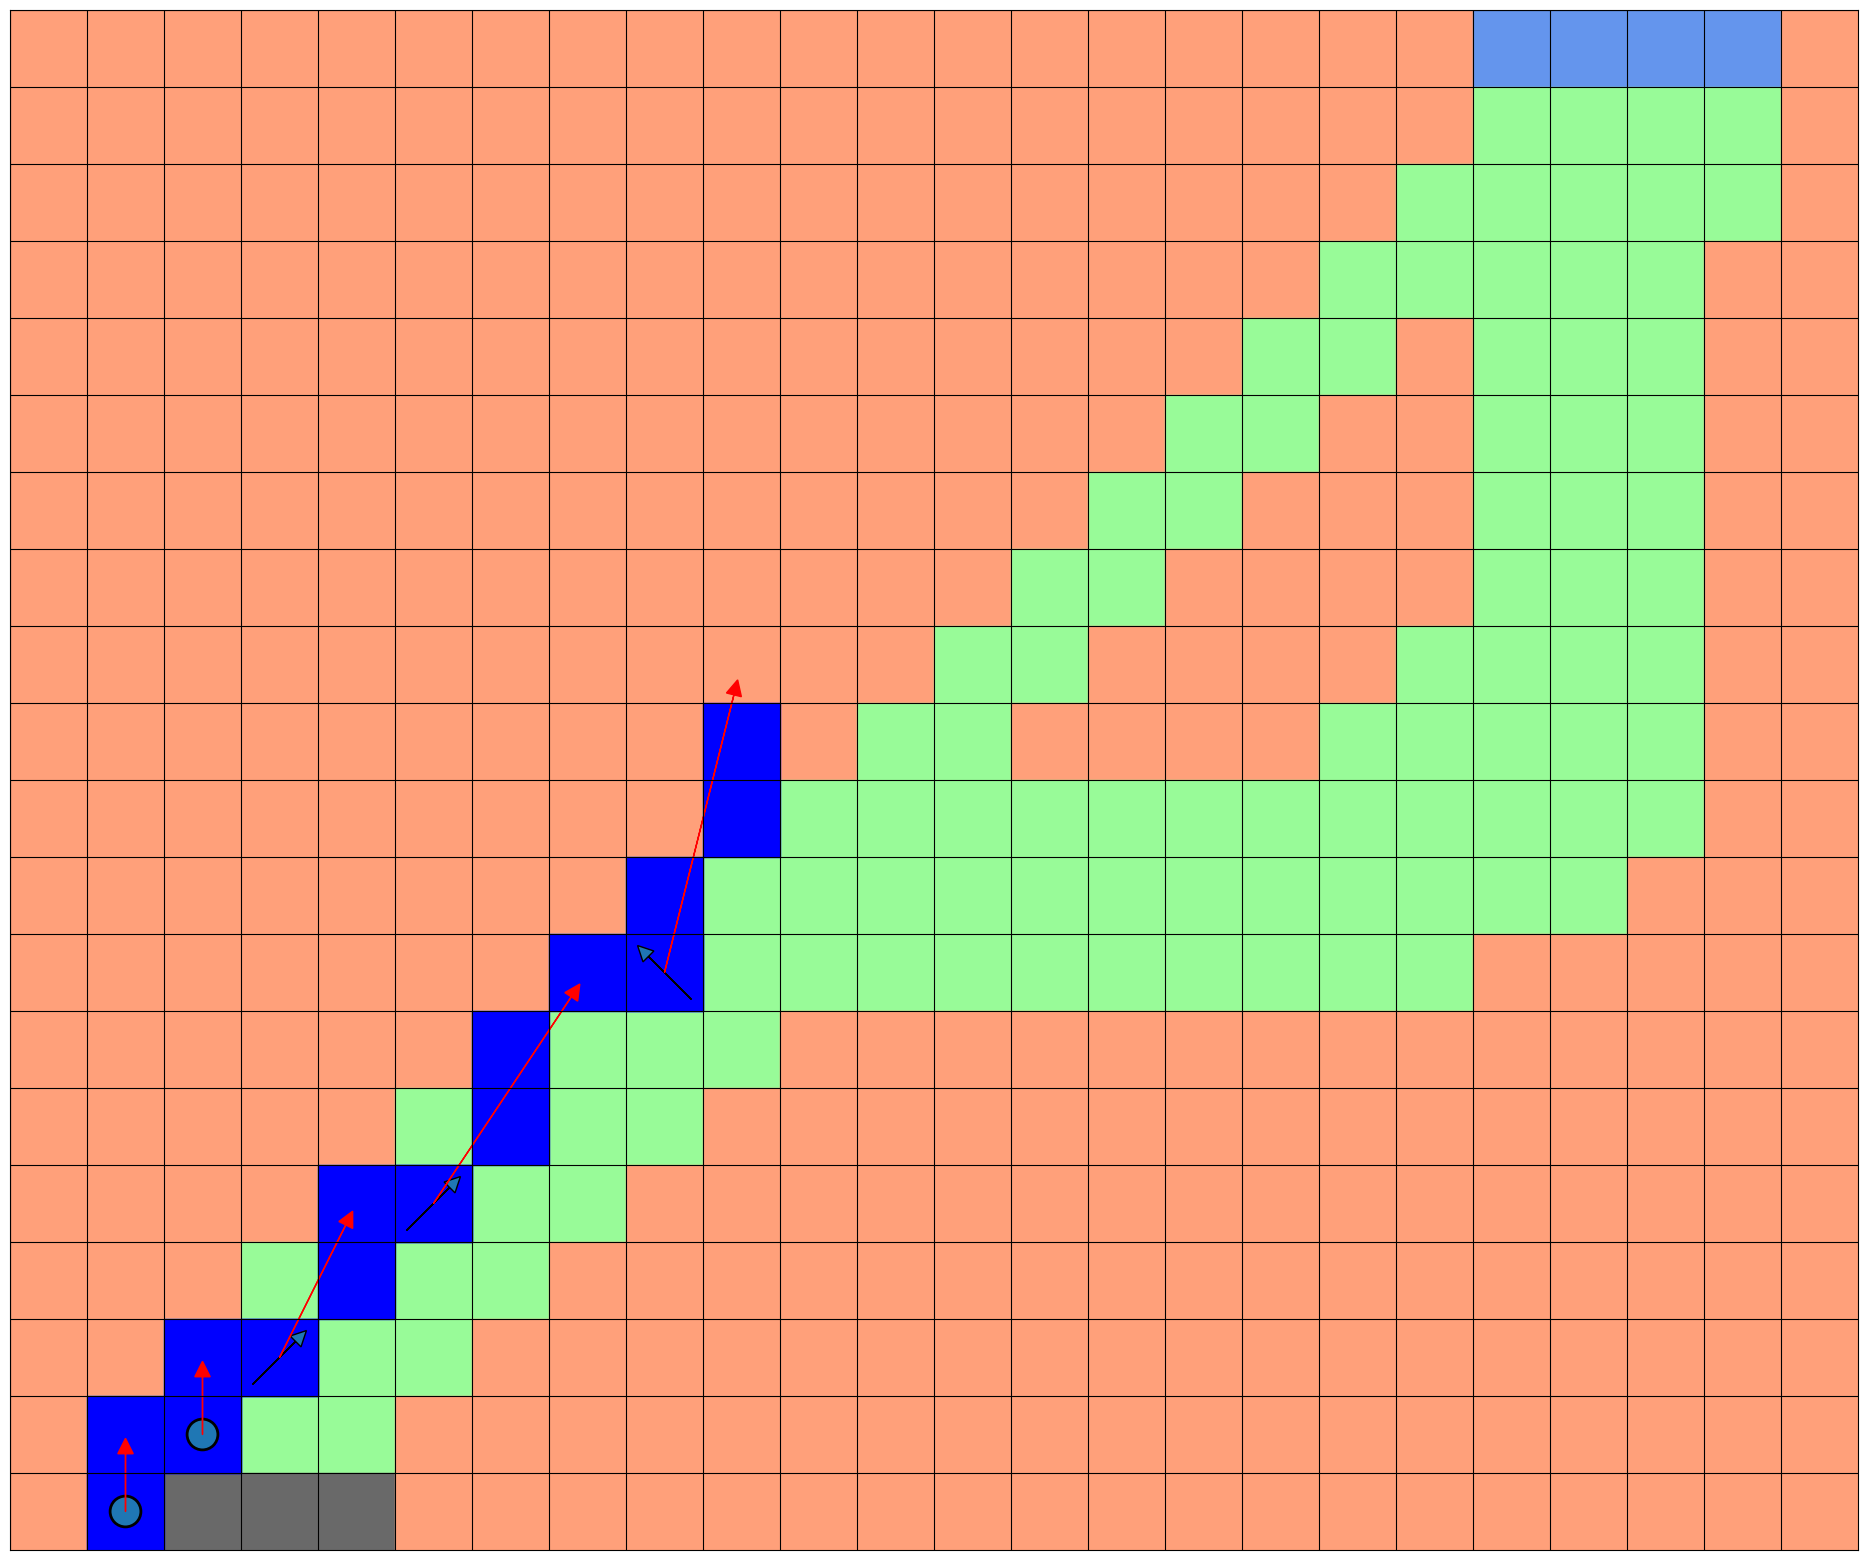

In [1]:
import numpy as np
# get the required helper class and visualization function
from helpers.utils import env, drawTrajectory, racetrack

# this makes sure that our description of the episode visualization makes sense
np.random.seed(2022)

# create a racing environment
racer = env()
# reset the agent to one of the 4 starting cells at random
# do this before each new episode
racer.reset()
# you can also manually set the agent position if you want to examine its behaviour there
# for example: racer.setPosition(19,1)
# create flag tracking whether the episode is over
done = False

# create lists to save the trajectory and the decisions of the agent
actions = []
moves = []
velocities = []

# these following methods do what you would expect
# v is an integer in [0, 35] representing an encoded velocity
v = racer.getVelocity()
# y, x are both integers, together, they represent the agent location
y, x = racer.getPosition()
# together (y, x, v) corresponds to the state of the environment

# simulate until the episode is over
while not done:
    # which actions are possible at the current velocity?
    # the actions are encoded to integers in [0,8]
    possibleActions = racer.getAvailableActions()
    # select one of them randomly
    a = np.random.choice(possibleActions)
    # save the action
    actions.append(a)
    # execute the action using the step function
    # y, x, v are new positions and velocities
    # done is the flag whether the episode is over
    # travel details exactly which cells the agent traveled through
    y, x, v, r, done, travel = racer.step(action = a, deviation = True)
    # save the velocities
    velocities.append(v)
    # save the cells that the agent most recently passed through
    # they are only needed for visualization
    moves.append(travel)

# use the helper function to display how the episode went
drawTrajectory(moves, actions, velocities)

The agent enters the section on one of the gray cells at the bottom. Its initial velocity is one cell per time step into the upward direction.

Actions are to increase or decrease its velocity components by one or to leave it unchanged. To clarify, the actions are not to set a velocity, but to accelerate or decelerate. The velocity is thus part of the agent's state, the available actions are accelerations within the physical limitations of the vehicle that the agent is driving. The agent is not in full control of the vehicle and always moves one cell too far in either the horizontal or vertical direction.

Both velocity components are restricted to be nonnegative and their sum must be at least 1 and cannot exceed 6. This constrains the available actions based on the agent's current velocity.

The rewards are $-1.5$ for each step that the agent stays on the track, which is colored green. The reward is $−17$ if the agent drives into the crash barriers marked in red. The episode ends when the agent crashes or when it succesfully exits the section by driving onto the blue line at the top-right of the grid, yielding a reward of $14$.

As an output to the cell above, you get a visualization of the agent's path through the race track section. You can see several cells marked in dark blue. These are the grid cells that the agent passed through. Between two time steps, they are calculated by a line drawing algorithm given the current position and velocity of the agent, as well as the acceleration it selected. This acceleration is represented by the arrows with the blue tips. In some cases, a cell will instead contain a circle. This represents the action of no acceleration or deceleration at all, which means that the velocity stays the same as in the previous time step. The red arrows show the velocity of the agent at a certain step after the acceleration the agent selected is added to it. 

## Task 4.1)

Compute an optimal policy  $\pi^*(s,a)$ for an agent on the windy (*deviation = True*) racetrack using Sarsa with $\alpha = 0.2$, $\gamma = 0.9$ and $\varepsilon = 0.1$ for $200000$ episodes.

To verify your algorithm, show one trajectory beginning in each of the $4$ starting positions. Deactivate exploratory actions and random environment deviations before presenting your agent's behaviour. 

<div style="text-align: right; font-weight:bold"> 10 Points </div>

In [54]:
from tqdm import tqdm

def sarsa_episode(Q, alpha, gamma, epsilon, is_training, starting_position = None):
    racer = env()
    racer.reset()
    done = False

    if starting_position:
        racer.setPosition(*starting_position)

    actions = []
    moves = []
    velocities = []
    return_total = 0

    v = racer.getVelocity()
    y, x = racer.getPosition()
    possibleActions = racer.getAvailableActions()
    a = choose_action(Q, epsilon,
                      (y, x, v[0]),
                      possibleActions,
                      is_training)
    actions.append(a)

    while not done:
        y_, x_, v_, r, done, travel = racer.step(action = a, deviation = True)
        velocities.append(v)
        moves.append(travel)

        possibleActions = racer.getAvailableActions()
        a_ = choose_action(Q, epsilon,
                      (y_, x_, v_[0]),
                      possibleActions,
                      is_training)
        actions.append(a_)

        # velocity is a list of one element, so we need to index it
        prev = Q[y, x, v[0], a]
        Q[y, x, v[0], a] = Q[y, x, v[0], a] + alpha * (r + gamma * Q[y_, x_, v_[0], a_] - Q[y, x, v[0], a])

        # print(f'Velocity: {racer.getVelocity()}')
        if not is_training:
             print(f"Update Q[{y}, {x}, {v[0]}, {a}] to {Q[y, x, v[0], a]}, previous value {prev}")

        y, x, v, a = y_, x_, v_, a_

        return_total += r

    if not is_training:
        drawTrajectory(moves, actions, velocities)
    return Q, return_total


def choose_action(Q, epsilon, state, possibleActions, is_training):
    y, x, v = state

    if np.all(Q[y, x, v, possibleActions] == 0):
        if not is_training:
            print("All actions have zero value")
        return np.random.choice(possibleActions)
    if np.random.uniform() < epsilon:
        if not is_training:
            print("Choosing random action")
        return np.random.choice(possibleActions)
    else:
        if not is_training:
            print("Choosing greedy action")
        return possibleActions[np.argmax(Q[y, x, v, possibleActions])]

# initialize Q(s,a) for all s,a
# Q = Q[y, x, v, a]
Q = np.zeros((20, 24, 36, 9))

# calculate moving average of return_episode
returns = []
for i in tqdm(range(200000)):
    Q, return_episode = sarsa_episode(Q, 0.2, 0.9, 0.1, is_training=True)
    returns.append(return_episode)

100%|██████████| 200000/200000 [06:20<00:00, 525.62it/s]


Choosing greedy action
Choosing greedy action
Update Q[19, 1, 6, 6] to -10.499016295530343, previous value -10.419285101564883
Choosing greedy action
Update Q[18, 3, 7, 5] to -10.071756111985898, previous value -10.353267857102425
Choosing greedy action
Update Q[16, 6, 14, 2] to -8.499317127439799, previous value -8.273010146133101
Choosing greedy action
Update Q[14, 8, 13, 1] to -8.37100186855325, previous value -8.782827836296205
Choosing greedy action
Update Q[12, 8, 6, 7] to -5.484588831897732, previous value -5.804108886201595
Choosing greedy action
Update Q[12, 10, 1, 6] to -2.665031377107028, previous value -3.007231794091421
Choosing greedy action
Update Q[12, 13, 2, 4] to 0.820998189747524, previous value 0.22641143425615862
Choosing greedy action
Update Q[11, 16, 8, 4] to 5.278143045060114, previous value 5.221494679681095
Choosing greedy action
Update Q[8, 18, 14, 2] to 7.92153135289386, previous value 7.783040562862434
Choosing greedy action
Update Q[5, 19, 13, 3] to 11.087

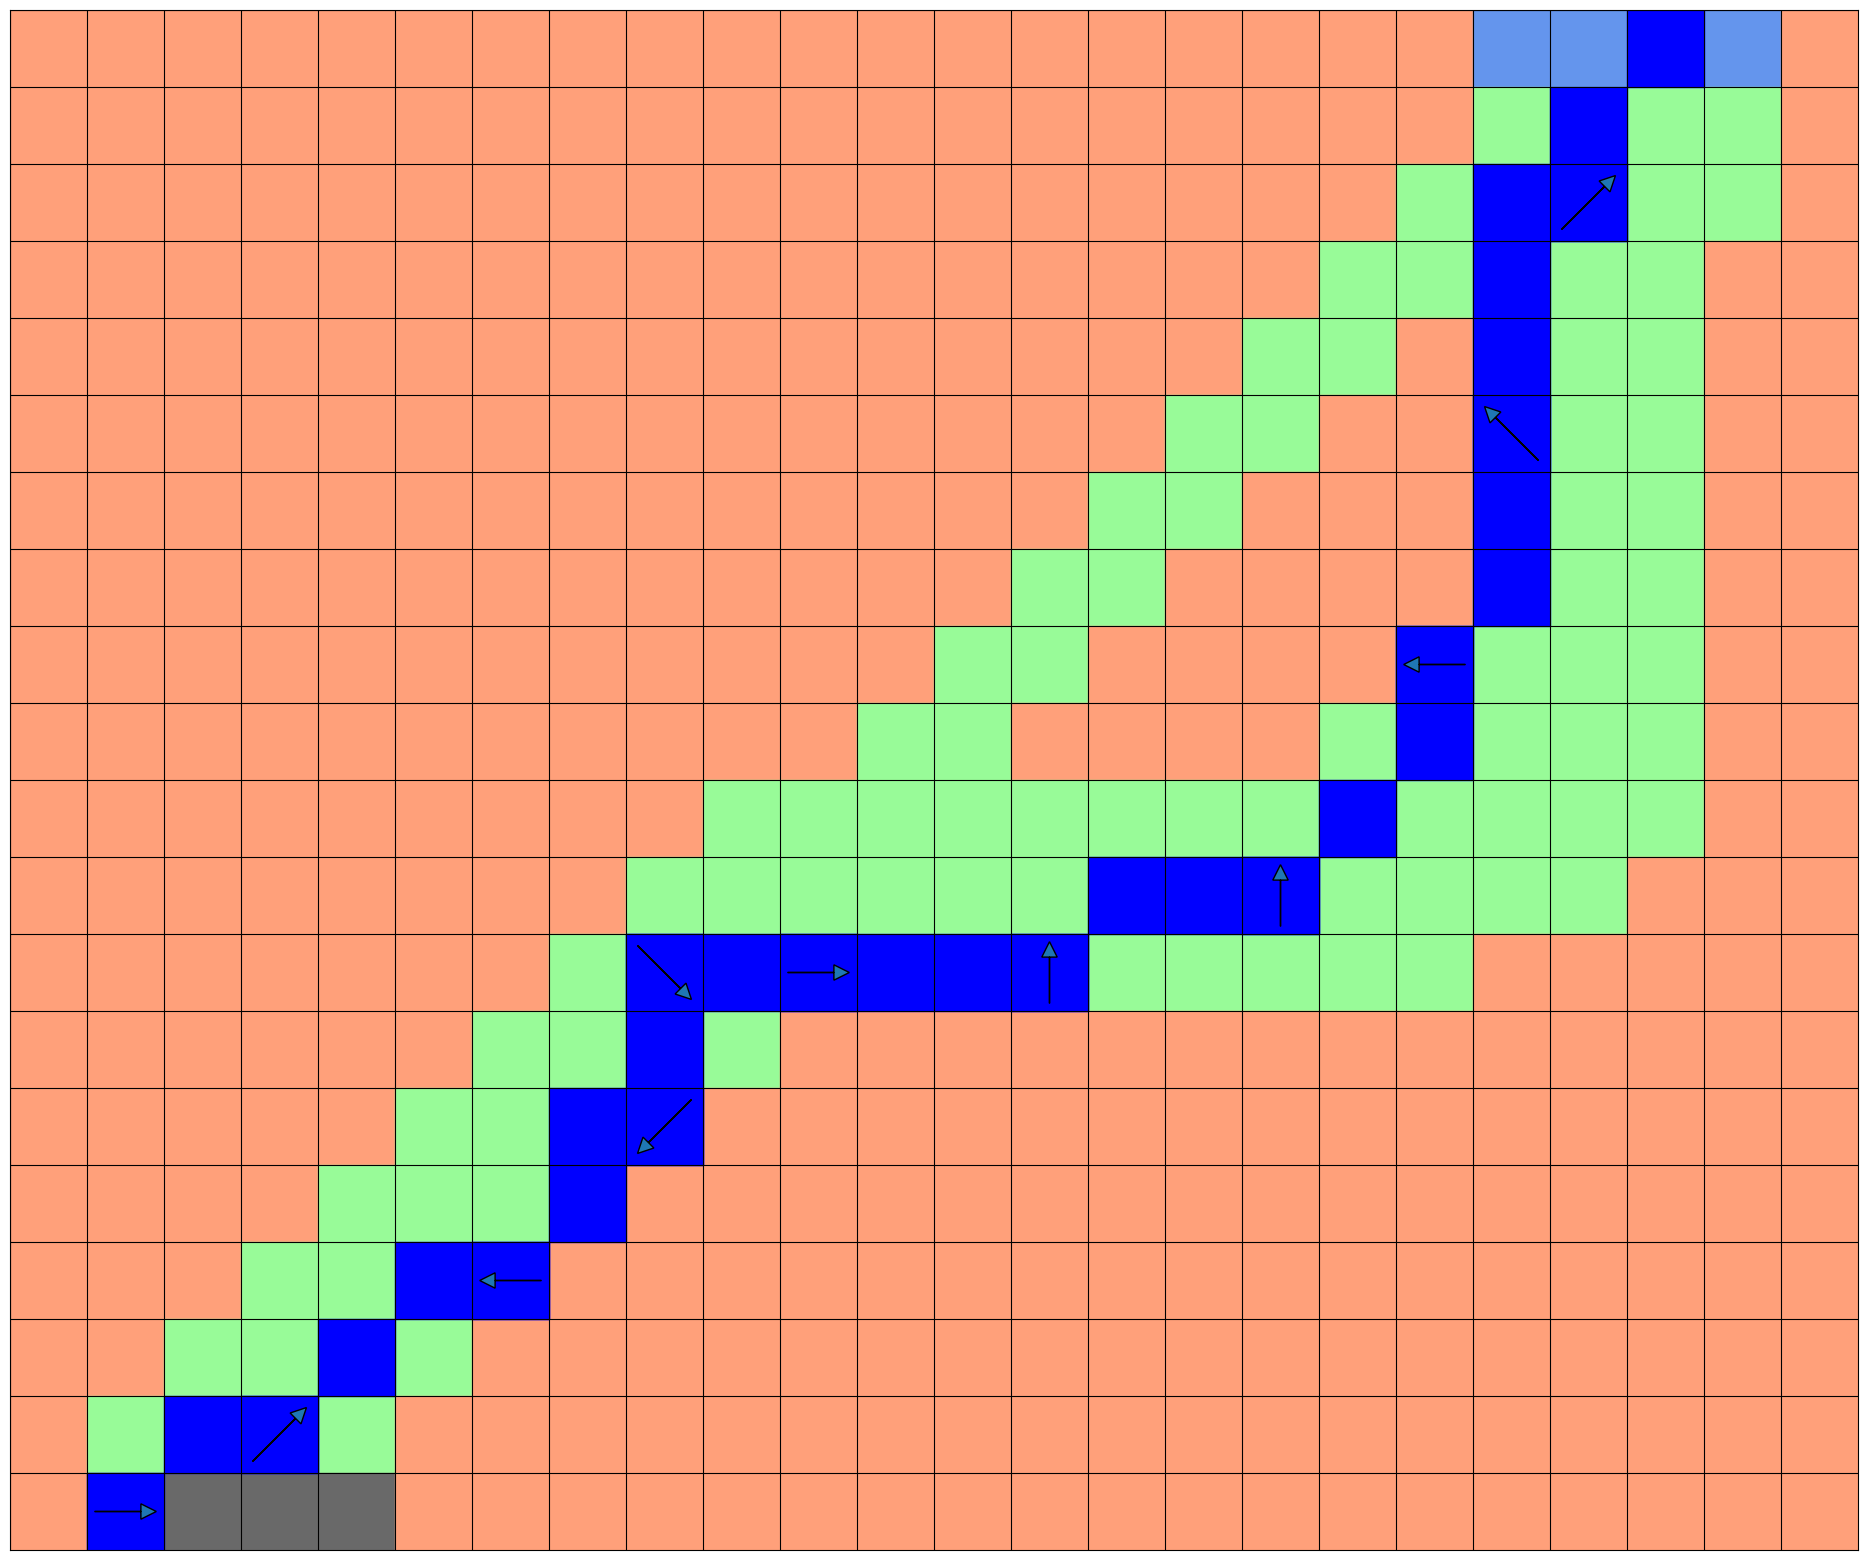

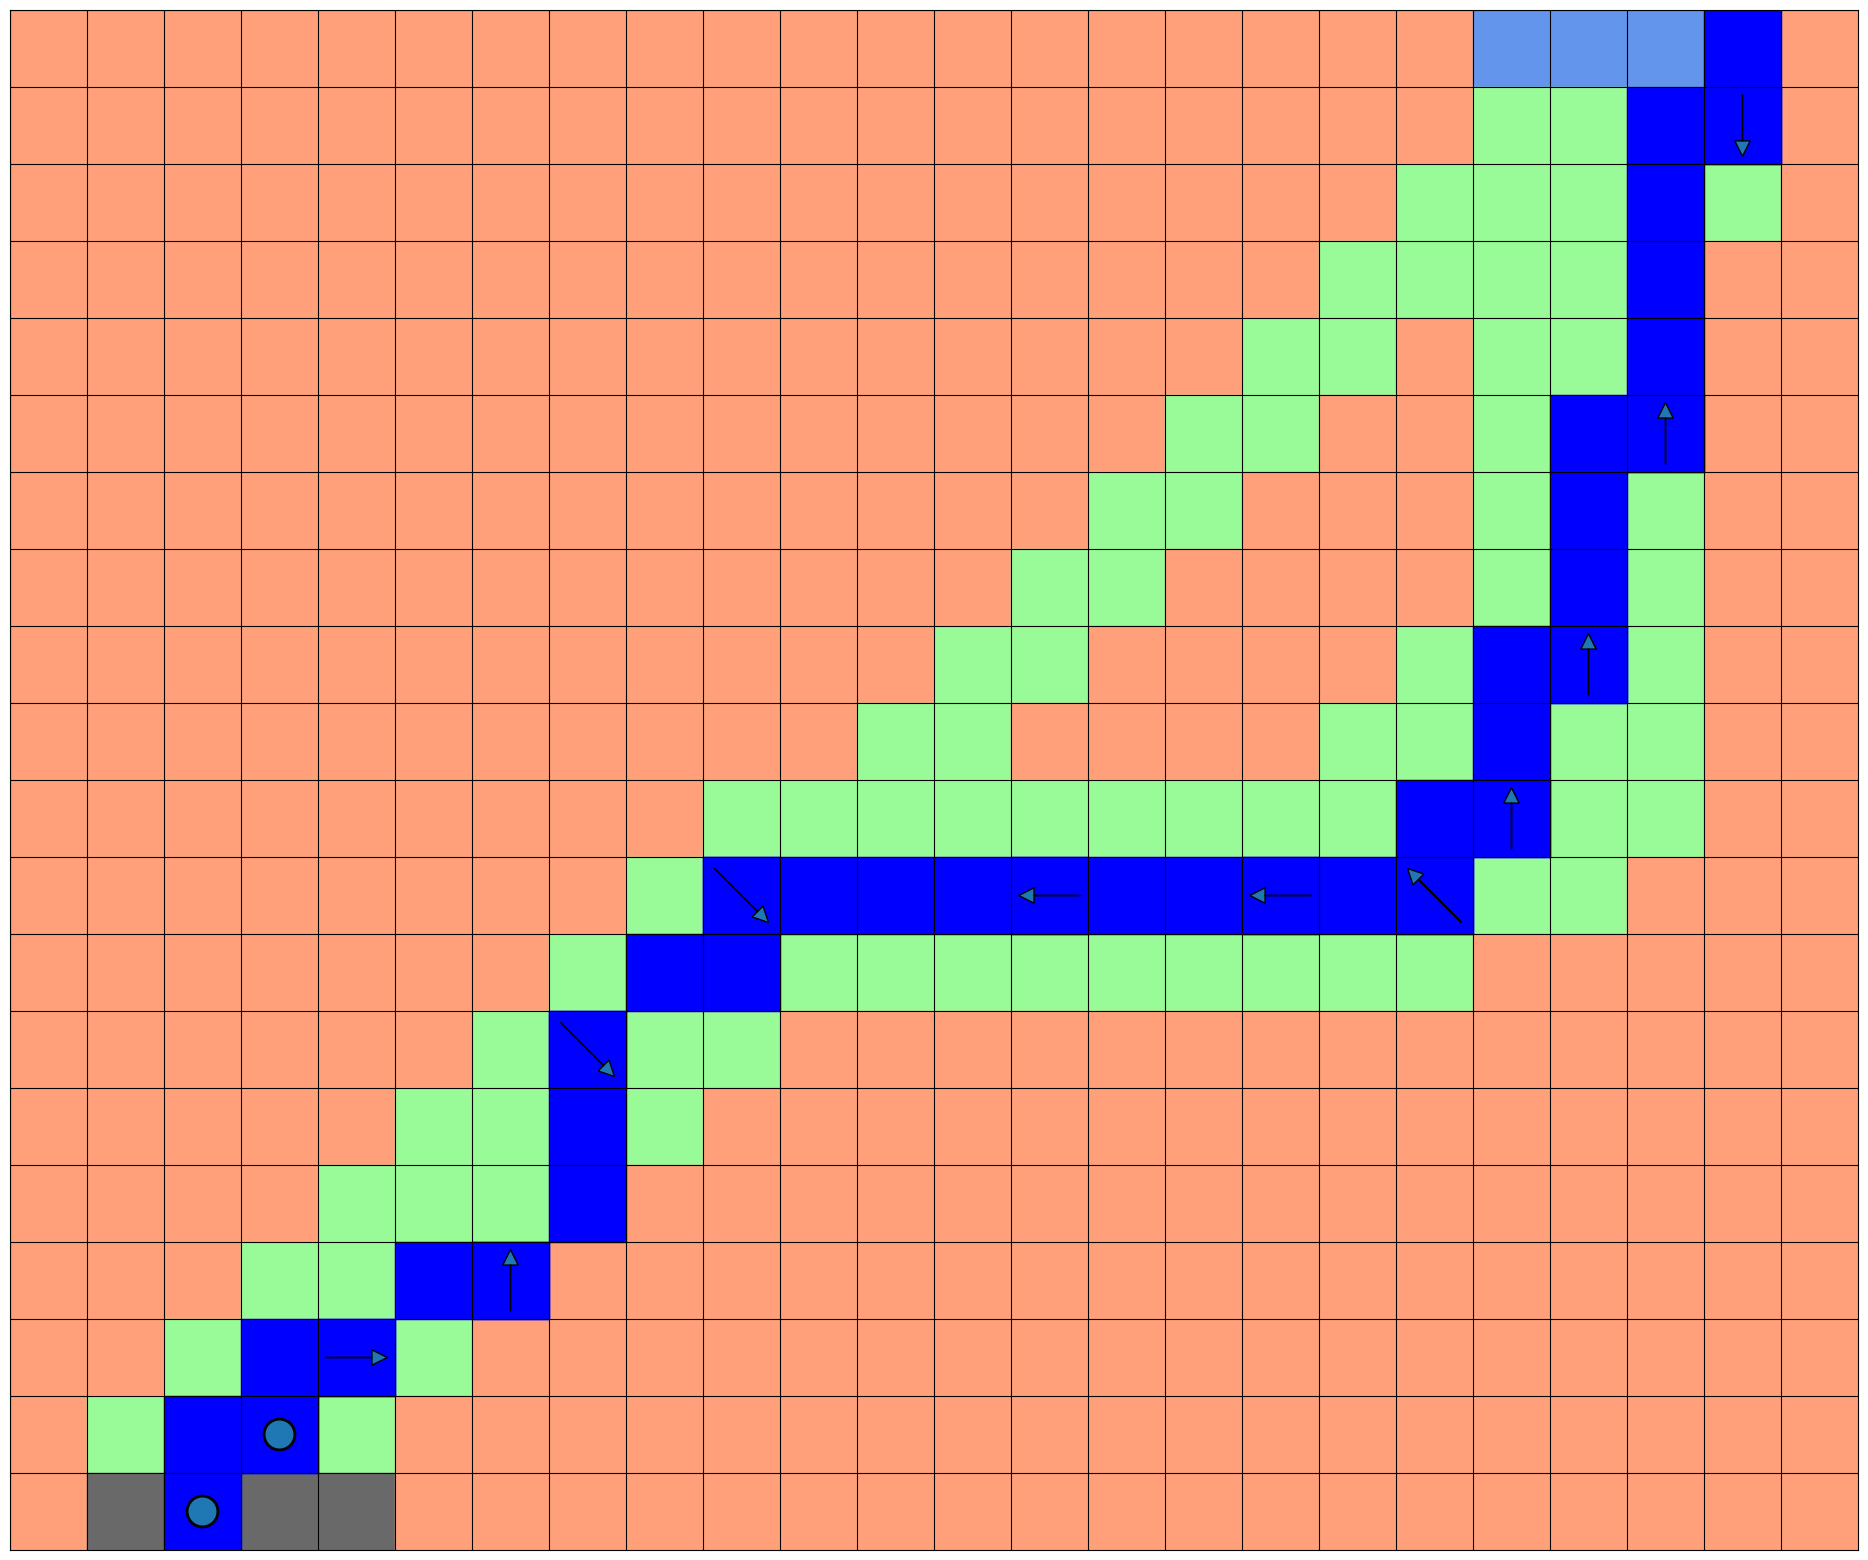

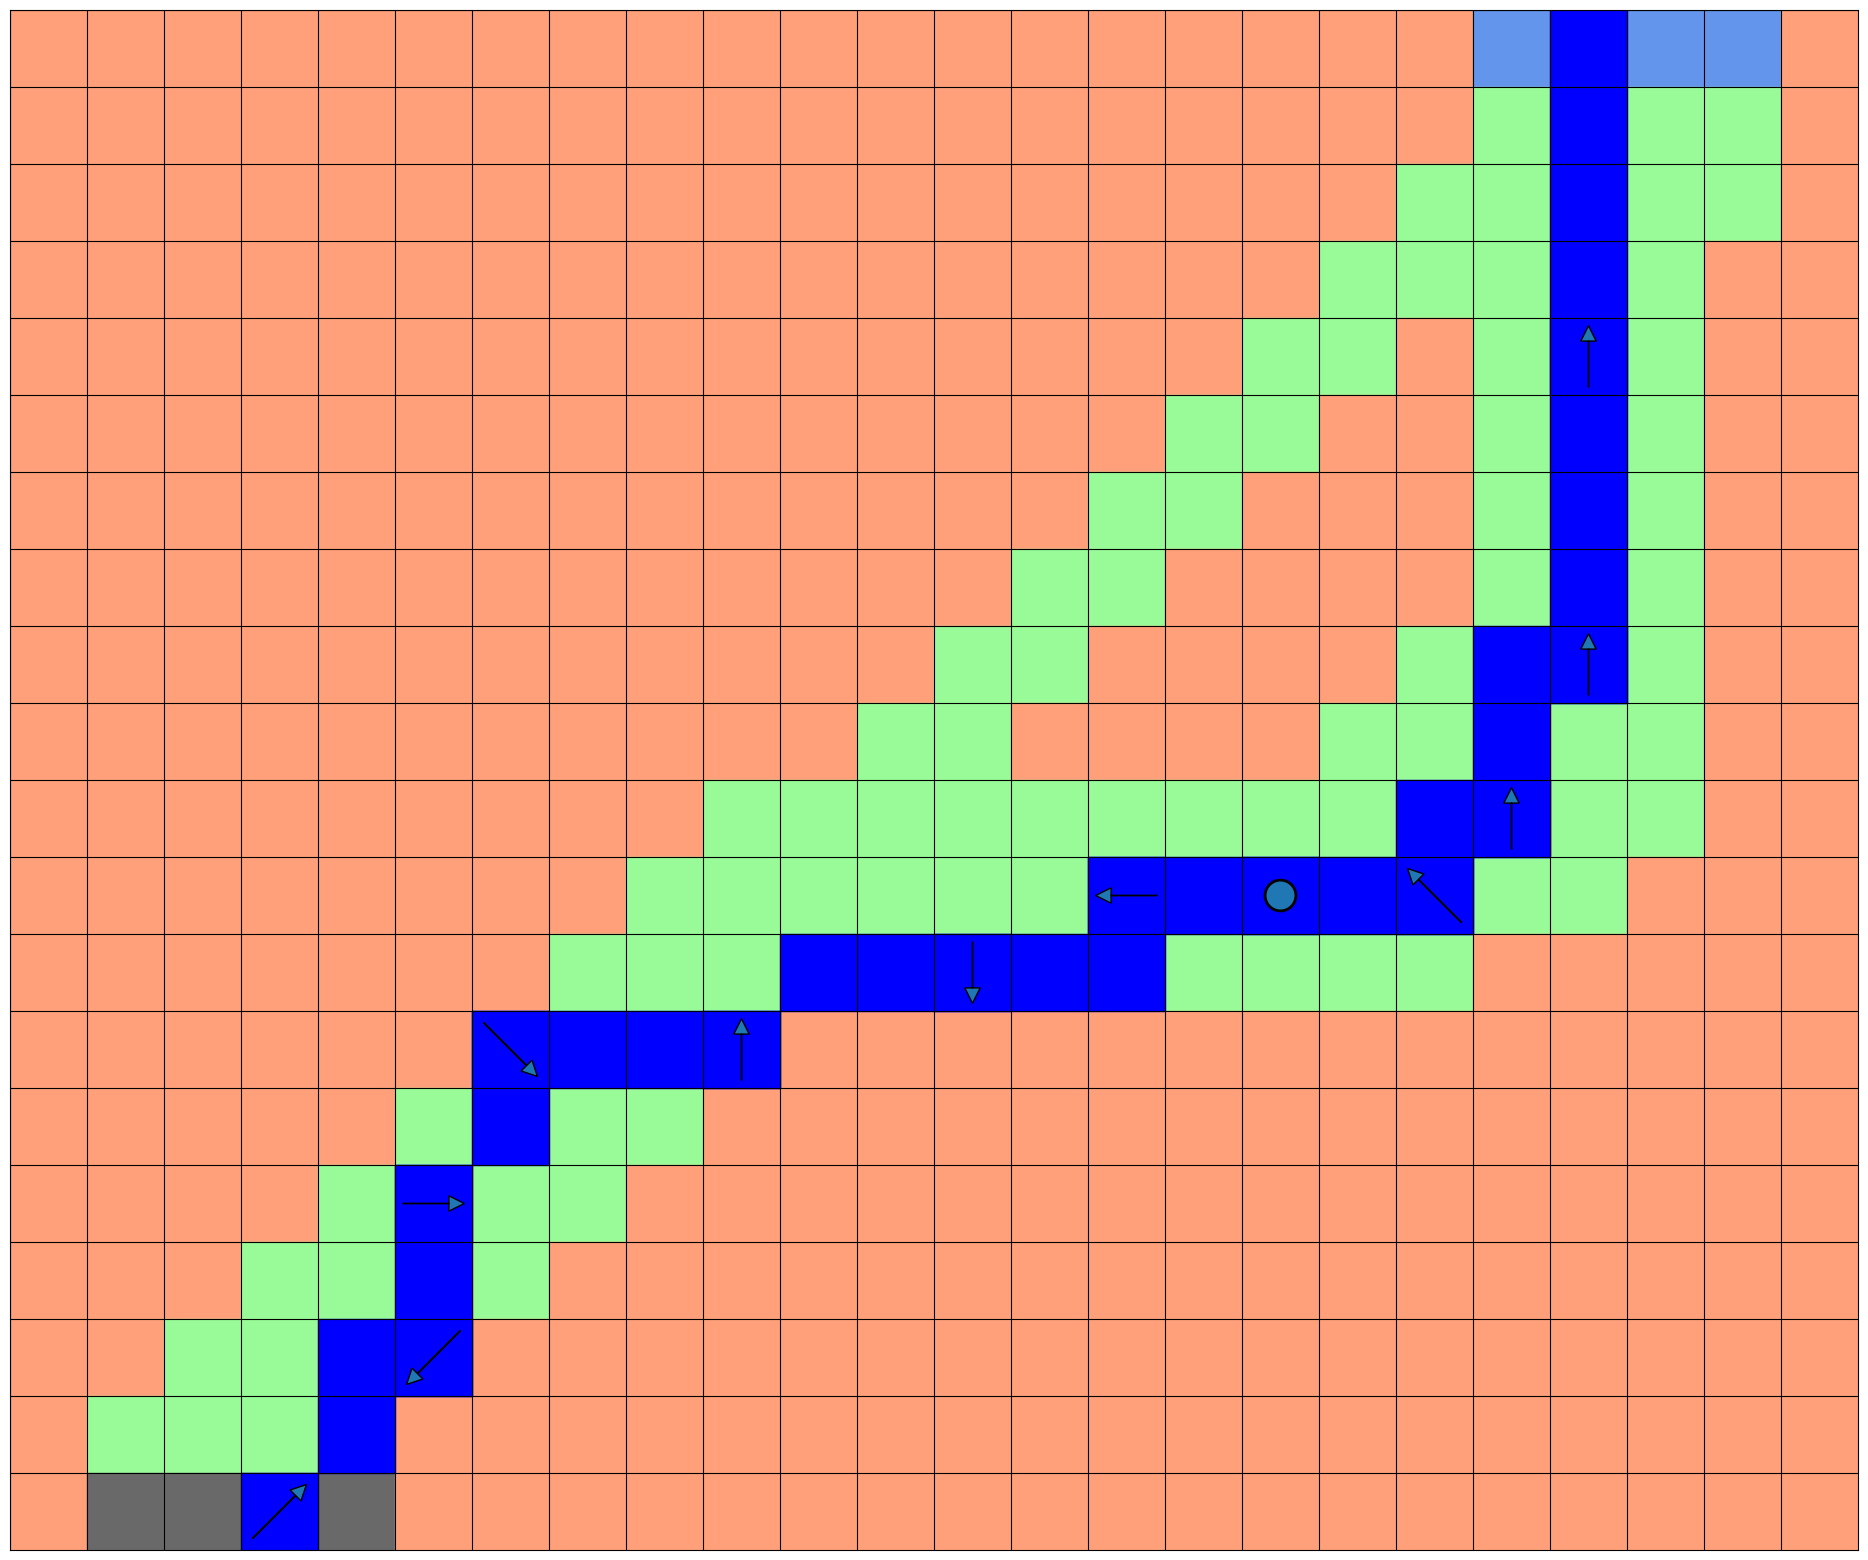

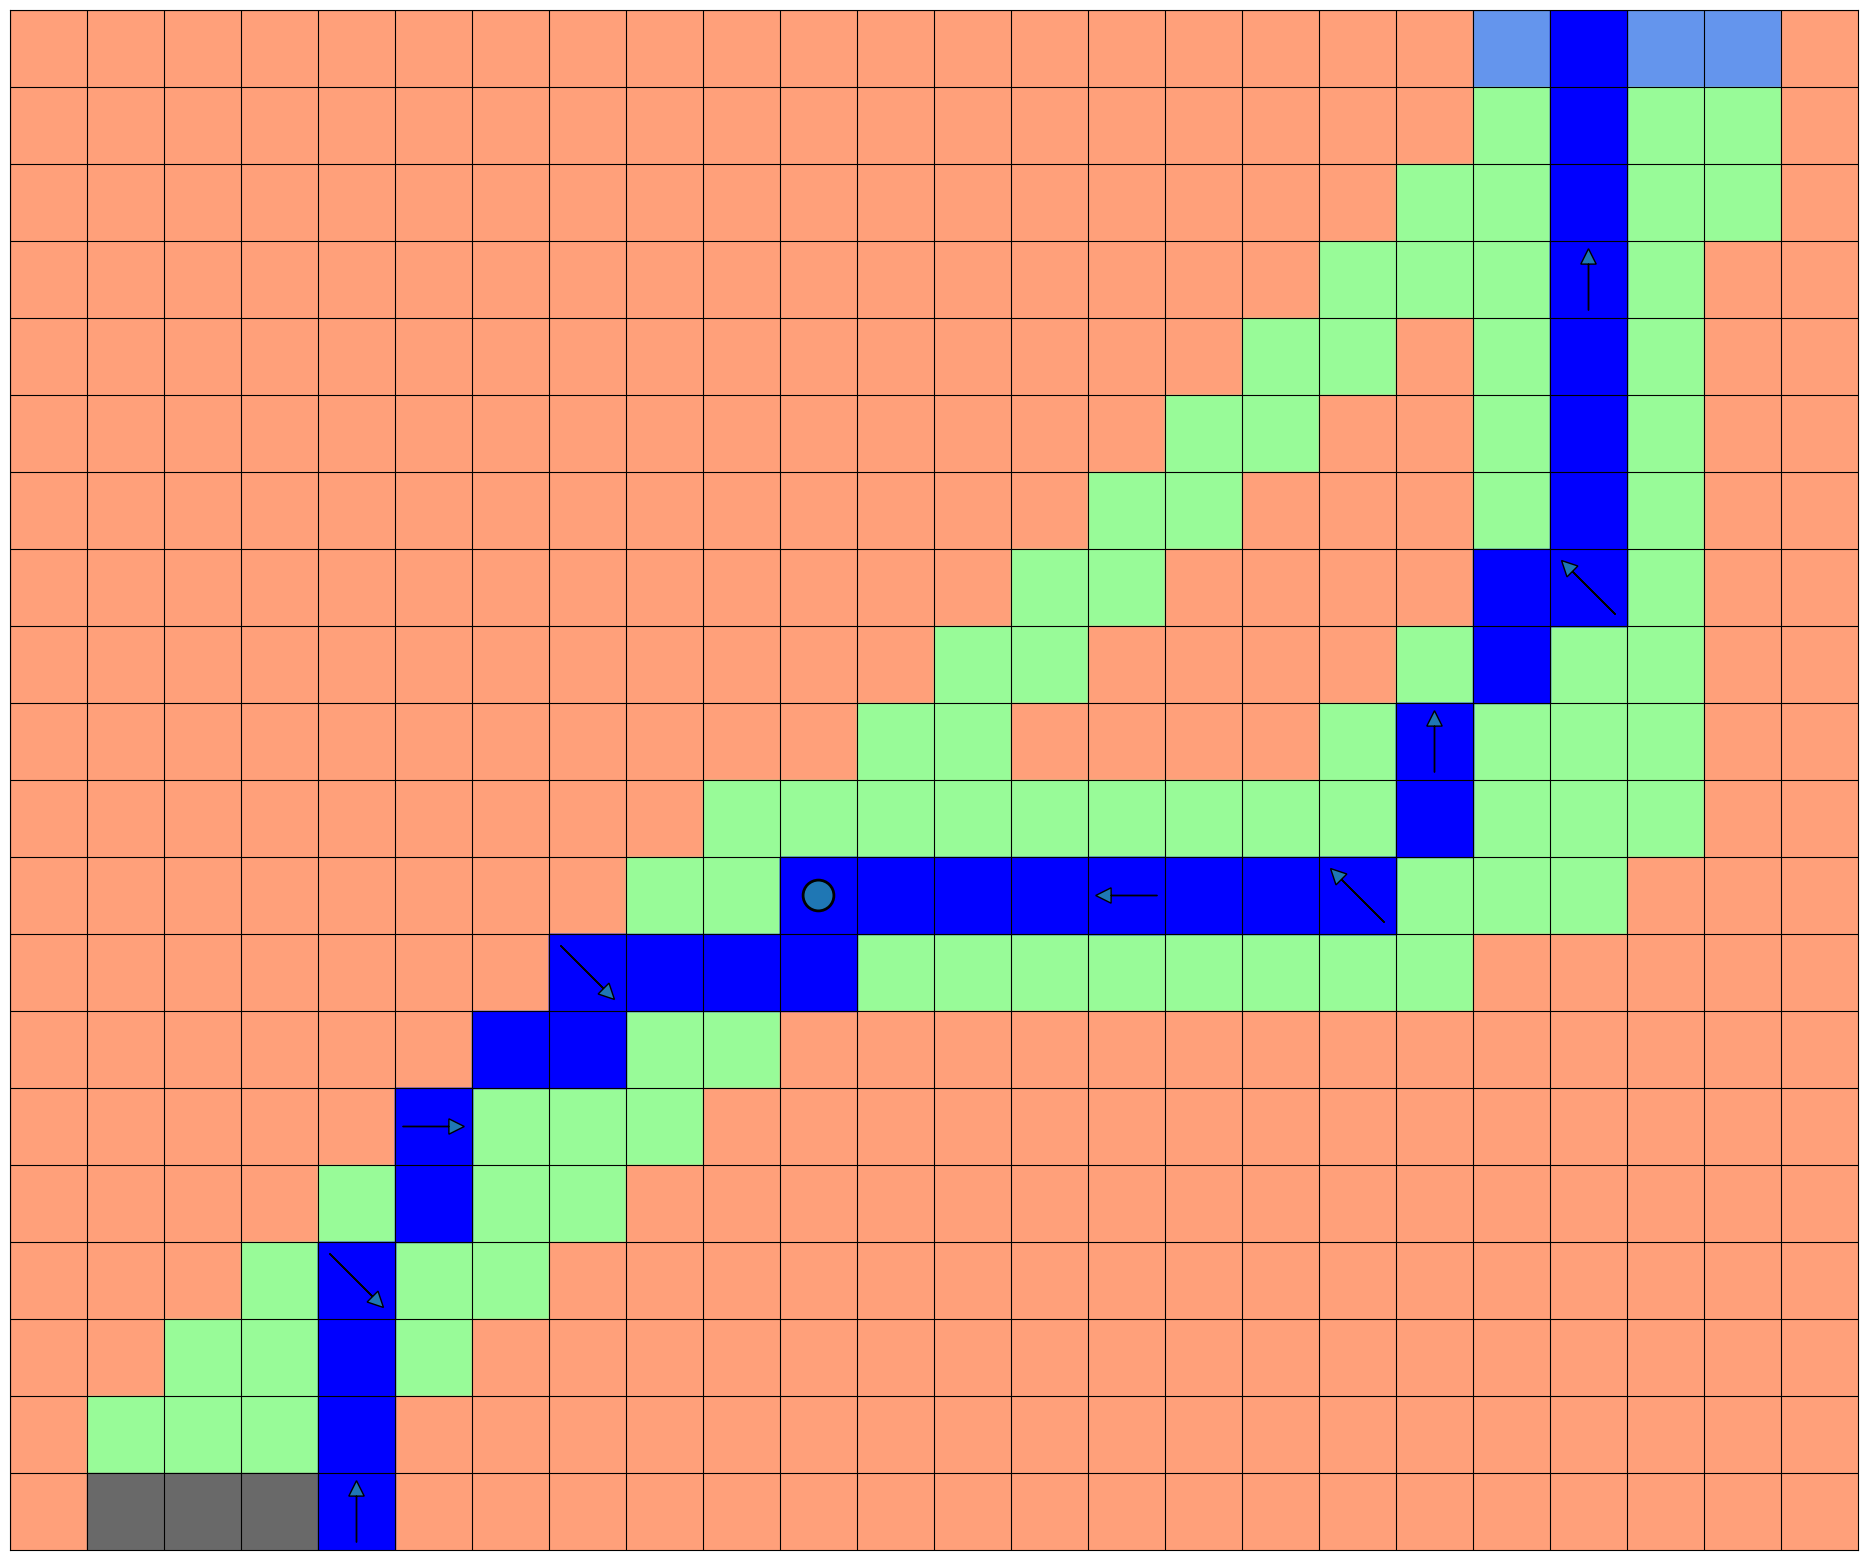

In [40]:
for starting_position in [(19,x) for x in np.arange(1,5)]:
    try:
        Q = sarsa_episode(Q, 0.2, 0.9, 0.0, is_training=False, starting_position=starting_position)
    except:
        pass

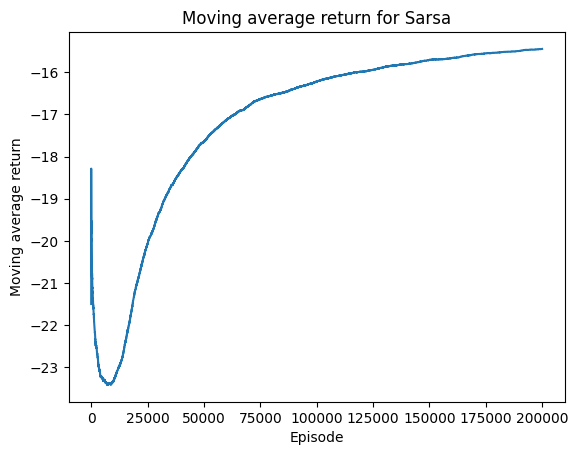

In [55]:
from matplotlib import pyplot as plt

# moving average of returns for task 4.2
# make list of moving averages of returns
moving_average_return = np.cumsum(returns) / np.arange(1, len(returns) + 1)

plt.plot(moving_average_return)
plt.xlabel("Episode")
plt.ylabel("Moving average return")
plt.title("Moving average return for Sarsa")

plt.show()

## Task 4.2)

Again compute an optimal policy  $\pi^*(s,a)$ for an agent on the windy (*deviation = True*) racetrack. This time, use Q-learning with $\alpha = 0.2$, $\gamma = 0.9$ and $\varepsilon = 0.1$ for $200000$ episodes. To verify your algorithm, show one trajectory beginning in each of the $4$ starting positions. Deactivate exploratory actions and random environment deviations before presenting your agent's behaviour. 

Compare your results with those for Sarsa by reporting the cumulative moving average episode return of both algorithms during training in a plot. 

<div style="text-align: right; font-weight:bold"> 4+3 = 7 Points </div>

In [3]:
# your code goes here


In [ ]:
# sarsa was done in task 4.1

## Task 4.3)

Note that the reward structure on this sheet differs from the previous assignment sheet, where driving on the track yielded a reward of $0.1$ instead of $-1.5$. Discuss whether it would be more or less difficult for Monte Carlo control algorithms to find a policy which is able to clear the racetrack in this scenario. Is there an advantage of using $-1.5$ as a reward?

<div style="text-align: right; font-weight:bold"> 3 Points </div>

Please answer in this text cell.